In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/cashierless-model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

In [ ]:
%%bash
pip install torch
pip install torchvision
pip install transformers
pip install requests
pip install timm
pip install datasets
pip install sahi
pip install roboflow
pip install fiftyone
pip install pytorch_lightning

## Test Model

In [ ]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw as D, ImageFont
import requests
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 

In [ ]:
def draw_bbox(image,box,label,score):
    dr = D.Draw(image)
    w = image.width
    h = image.height
    text = str(label) + ": " + str(score) + "%"

    try:
        fnt = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.tiff", 25)
    except IOError:
        print("Font not found, using default font.")
        fnt = ImageFont.load_default()

    label_span_w,label_span_h = fnt.getsize(text)
    # draw bbox
    dr.rectangle([(box[0],box[1]),(box[2],box[3])],outline="green",width=4)
    # draw label
    dr.rectangle([(box[0],box[1]),(box[0] + label_span_w,box[1] + label_span_h)],fill="green",outline="green",width=4)
    dr.text(
        (box[0], box[1]),
        text,
        font=fnt,
        fill="white")
    return image

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039768.jpg"
url = "https://farm3.staticflickr.com/2130/2157171861_e6a9b8aae0_z.jpg"
url = "https://farm1.staticflickr.com/55/126480503_6d7577043a_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)
_image = image.copy()

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = feature_extractor.post_process(outputs, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [int(i) for i in box.tolist()]
    _score = round(score.item(), 3) * 100
    _label = model.config.id2label[label.item()]
    # let's only keep detections with score > 0.9
    if score > 0.9:
        print(
            f"Detected {_label} with confidence "
            f"{_score} at location {box}"
        )
        _image = draw_bbox(_image,box,_label,_score)


In [ ]:
_image

# Fined-Tuning

## Prepare Dataset

### 1. From Roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="AYEg9VSfc2eDUkVs7wXy")
project = rf.workspace("school-czl2e").project("snacks-xz9tx")
dataset = project.version(6).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to snacks-6 in coco:: 100%|██████████| 792/792 [00:00<00:00, 1723.25it/s]


In [ ]:
dataset_path = "/content/snacks-6"
data_dir = ""

convert pascal voc-xml to coco
1. scratch: https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html
2. Library and Roboflow: https://blog.roboflow.com/how-to-convert-annotations-from-voc-xml-to-coco-json/

### 2. from Drive

In [ ]:
dataset_path = "/content/drive/MyDrive/cashierless-model/images"
data_dir = "images"

## Preprocessing & DataLoading

In [ ]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [ ]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder=f'{dataset_path}/train', feature_extractor=feature_extractor)
test_dataset = CocoDetection(img_folder=f'{dataset_path}/test', feature_extractor=feature_extractor)
valid_dataset = CocoDetection(img_folder=f'{dataset_path}/valid', feature_extractor=feature_extractor)

Downloading:   0%|          | 0.00/274 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 693
Number of test examples: 30


Image n°150
Font not found, using default font.


getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.


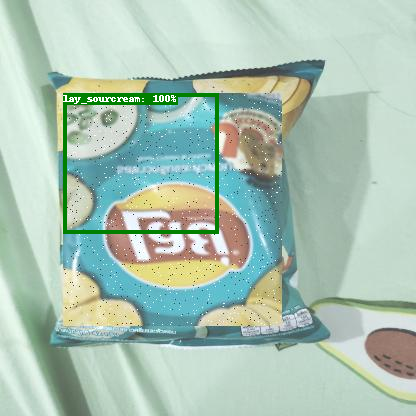

In [ ]:
# Example
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{dataset_path}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
label2id = {v['name']: k  for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  draw_bbox(image,box, id2label[class_idx], 100)

image

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

## Loading Pre-trained Model

In [ ]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Downloading:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [ ]:
batch_size = 4
epochs = 50 * (len(train_dataset) / batch_size) # epochs * steps
ckpt_path="/content/drive/MyDrive/cashierless-model/models/Detr"

Example: https://www.kaggle.com/code/nouamane/fine-tuning-detr-for-license-plates-detection

- ### Newly Fit

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

ckpt = ModelCheckpoint(dirpath=ckpt_path, filename='2cl-{epoch}-{val_loss:.2f}-{other_metric:.2f}' )
trainer = Trainer(callbacks=[ckpt],accelerator='gpu', devices=1, max_steps=epochs, gradient_clip_val=0.1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.039   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

- ### Load Checkpoint

In [ ]:
from pytorch_lightning import Trainer
from tqdm.notebook import tqdm
 
ckpt_file = "/" + "epoch=109-val_loss=0.00-other_metric=0.00.ckpt"
trainer = Trainer(accelerator='gpu', devices=1, max_steps=epochs + 500, gradient_clip_val=0.1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, ckpt_path=ckpt_path + ckpt_file)

## Inference + Vislualization

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

In [ ]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.9, keep_highest_scoring_bbox=False):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  if keep_highest_scoring_bbox:
    keep = probas.max(-1).values.argmax()
    keep = torch.tensor([keep])
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    
  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [ ]:
it = iter(range(10))

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = valid_dataset[next(it)]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = valid_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{dataset_path}/valid', image['file_name']))

visualize_predictions(image, outputs, threshold=0.3, keep_highest_scoring_bbox=True)

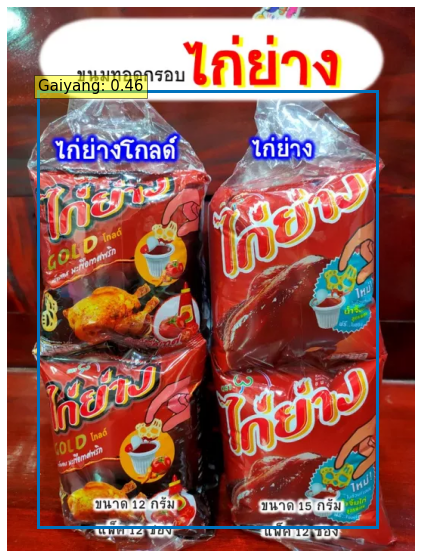

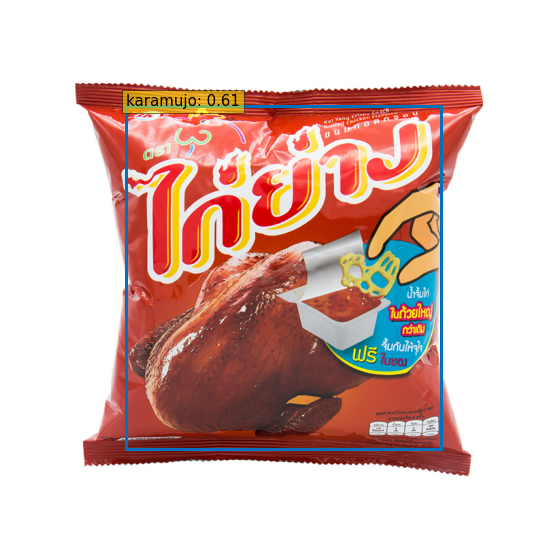

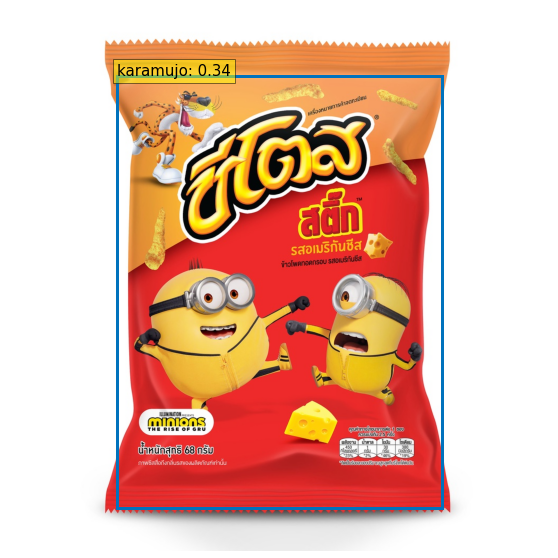

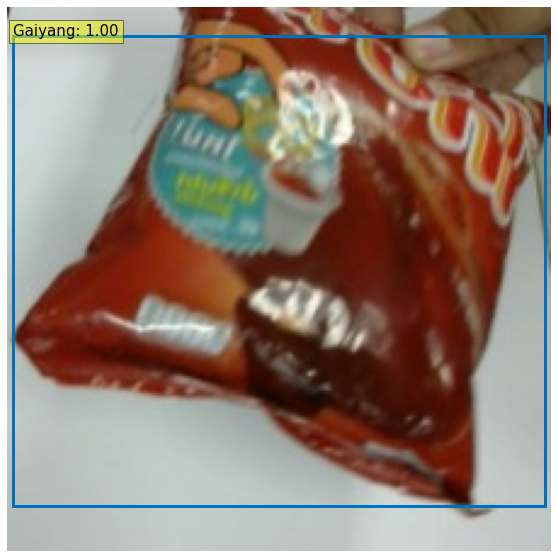

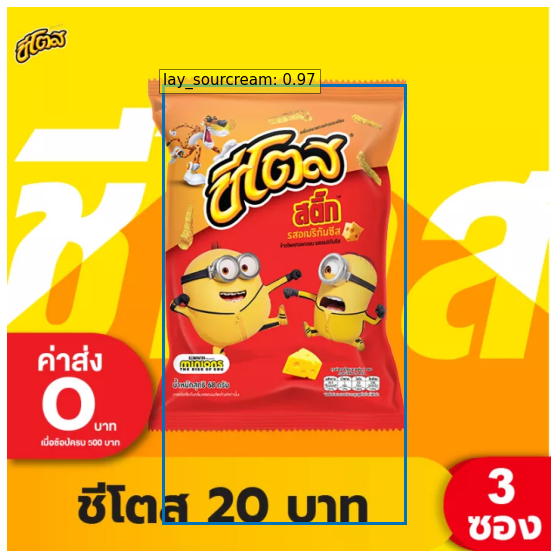

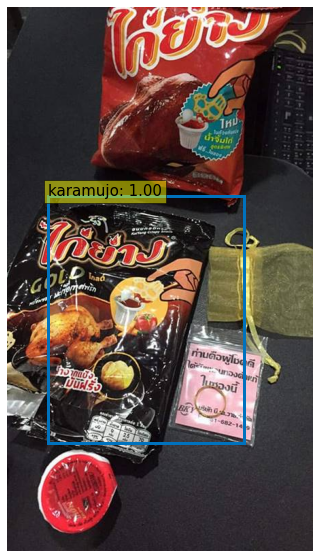

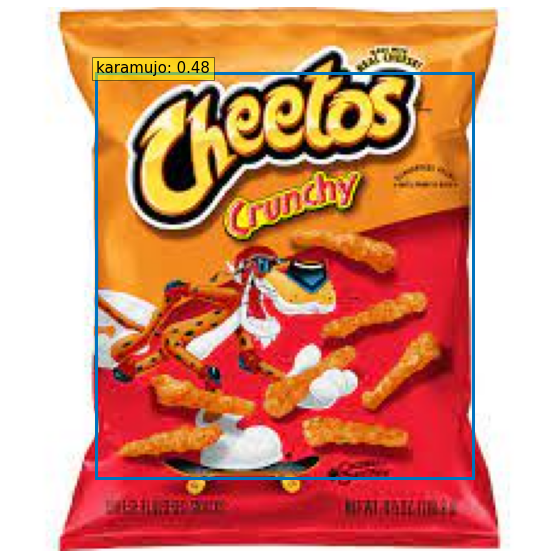

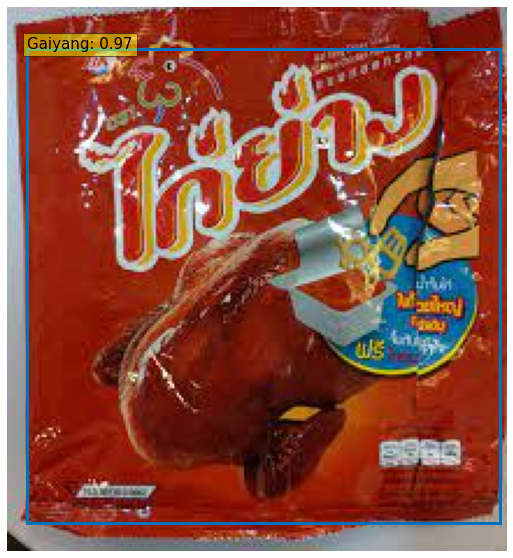

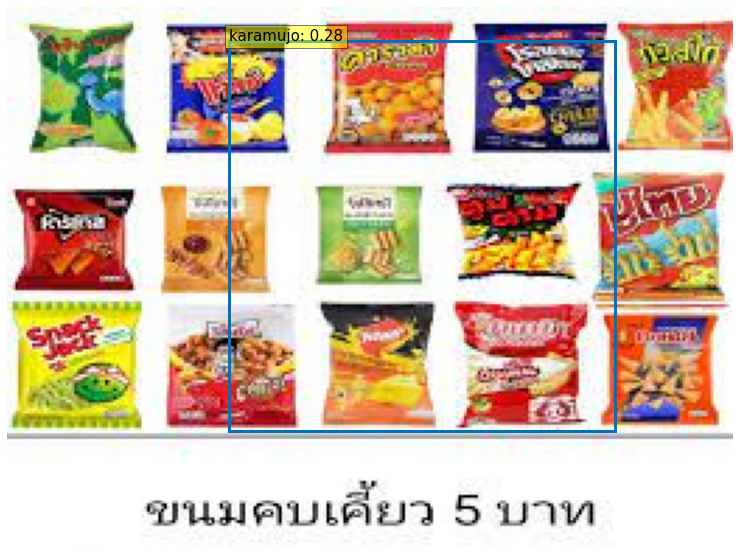

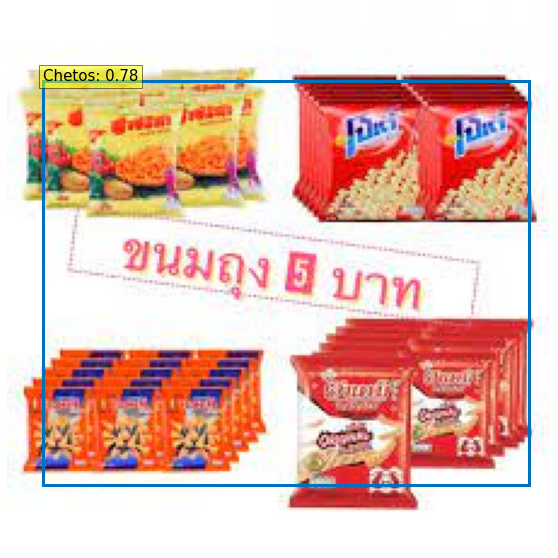

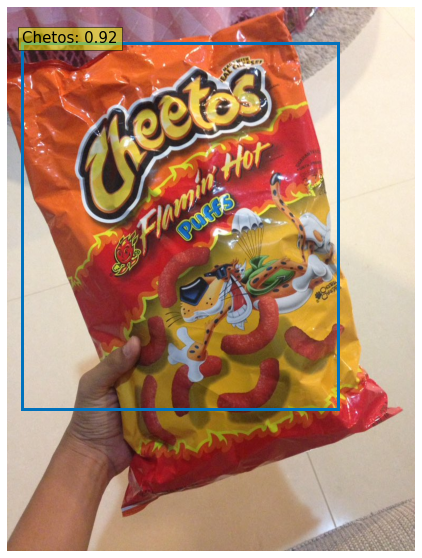

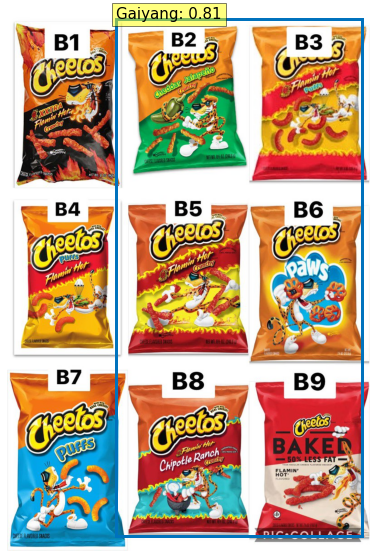

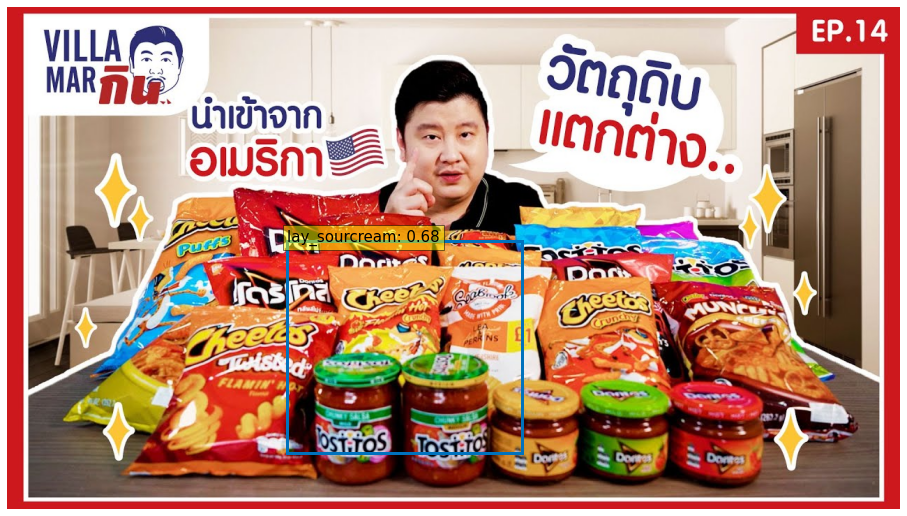

In [ ]:
import glob
for im in glob.glob("/content/drive/MyDrive/cashierless-model/images/validate/*"):
    image = Image.open(im)
    encoding = feature_extractor(images=image, return_tensors="pt")
    pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
    pixel_values = pixel_values.unsqueeze(0).to(device)
    outputs = model(pixel_values=pixel_values, pixel_mask=None)
    visualize_predictions(image, outputs, threshold=0.3, keep_highest_scoring_bbox=True)

In [ ]:
trainer.save_checkpoint("/content/drive/MyDrive/cashierless-model/models/Detr/detr_model-4cl-54ep.ckpt")